In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.cluster import KMeans
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity

In [2]:
# AZURE_OPENAI_KEY = ""
AZURE_OPENAI_ENDPOINT = "https://tmjg-t-eu-openai-test-01.openai.azure.com/"
openai.api_key = AZURE_OPENAI_KEY
openai.api_base = AZURE_OPENAI_ENDPOINT
openai.api_type = 'azure'
openai.api_version = '2023-05-15'  # this may change in the future
DATAPATH = "process.csv"

In [87]:
def plot(label, vis_dims):
    n = label.nunique()
    colors = ["red", "darkgreen", "darkorange", "gold", "turquoise"][:n]
    
    x = [x for x,y in vis_dims]
    y = [y for x,y in vis_dims]
    color_indices = label

    colormap = matplotlib.colors.ListedColormap(colors)
    plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
    for score in range(n):
        avg_x = np.array(x)[label==score].mean()
        avg_y = np.array(y)[label==score].mean()
        color = colors[score]
        plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

    # plt.title("Amazon ratings visualized in language using t-SNE")
    plt.show()

In [224]:
df = pd.read_csv(DATAPATH)
df['ada_embedding'] = df.ada_embedding.apply(eval).apply(np.array)
print(df.columns)
print(df.shape)

Index(['comment', 'label', 'n_tokens', 'feedback', 'ada_embedding'], dtype='object')
(692, 5)


In [225]:
df.head(2)

,comment,label,n_tokens,feedback,ada_embedding
0,Wow... Loved this place.,1,6,Customer had a great experience at the place.,"[0.00471370667219162, -0.004431409761309624, 0..."
1,Crust is not good.,0,6,Customer did not like the crust.,"[0.017028724774718285, -0.01575792394578457, 0..."


In [226]:
matrix = np.array(df['ada_embedding'].values.tolist())
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
print("matrix.shape:", matrix.shape)
print("vis_dims.shape", vis_dims.shape)

matrix.shape: (692, 1536)
vis_dims.shape (692, 2)


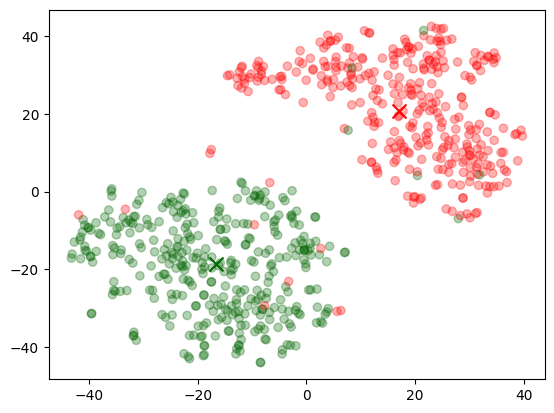

In [195]:
plot(df.label, vis_dims)

# Exam ouliers

In [196]:
mean_true = df[df["label"]==1]['ada_embedding'].mean(axis=0)
mean_false = df[df["label"]==0]['ada_embedding'].mean(axis=0)
# df["dist_true"] = df.ada_embedding.apply(lambda x: np.linalg.norm(x - mean_true))
# df["dist_false"] = df.ada_embedding.apply(lambda x: np.linalg.norm(x - mean_false))
df["dist_true"] = df.ada_embedding.apply(lambda x: sum((x - mean_true)**2)**0.5)
df["dist_false"] = df.ada_embedding.apply(lambda x: sum((x - mean_false)**2)**0.5)

df.loc[df["label"]==1, 'dist_opposite'] = df["dist_true"] - df["dist_false"]
df.loc[df["label"]==0, 'dist_opposite'] = df["dist_false"] - df["dist_true"]

In [199]:
tmp = df[df["label"]==1].sort_values("dist_opposite", ascending=False).head()
for idx, item in tmp.iterrows():
    print(item["comment"], "|||", item["feedback"])
    print()

It was just not a fun experience. ||| Customer had an unpleasant experience.

The patio seating was very comfortable. ||| Customer feels the food lacked flavor and was poorly constructed.

The menu had so much good stuff on it i could not decide! ||| Customer had difficulty choosing from the menu.

Not a weekly haunt, but definitely a place to come back to every once in a while. ||| Customer would come back occasionally, but not regularly.

The only thing I did like was the prime rib and dessert section. ||| Customer only liked the prime rib and dessert section of the food.



In [200]:
tmp = df[df["label"]==0].sort_values("dist_opposite", ascending=False).head()
for idx, item in tmp.iterrows():
    print(item["comment"], "|||", item["feedback"])
    print()

There is nothing authentic about this place. ||| Customer loved the food and thought it was delicioso!

Not much flavor to them, and very poorly constructed. ||| Customer recommends the place for a sit-down family meal or get-together with friends.

It's NOT hard to make a decent hamburger. ||| Customer thinks it's easy to make a good hamburger.

seems like a good quick place to grab a bite of some familiar pub food, but do yourself a favor and look elsewhere. ||| Customer suggests to look for other places for food and mentioned this place as a quick option for familiar pub food.

I go to far too many places and I've never seen any restaurant that serves a 1 egg breakfast, especially for $4.00. ||| Customer thinks it's rare to find a 1 egg breakfast that only costs



# ML Regression 

In [201]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.ada_embedding.values),
    df.label,
    test_size = 0.2,
    random_state=42
)

In [202]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
acc = accuracy_score(y_test==1, preds>0.5)

print(f"ada-002 embedding performance on reviews: mse={mse:.2f}, mae={mae:.2f}, acc={acc:.2f}")

ada-002 embedding performance on reviews: mse=0.02, mae=0.07, acc=0.99


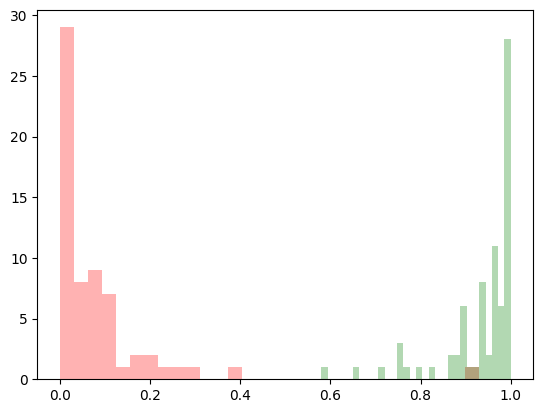

In [203]:
plt.hist(preds[y_test==0], color='red', alpha=0.3, bins=30)
plt.hist(preds[y_test==1], color='green', alpha=0.3, bins=30)
plt.show()

In [204]:
error = df[df.ada_embedding.apply(lambda x: all(x==np.array(X_test)[(y_test==0)][3]))]
print("comment: ", error.comment.values)
print("feedback: ", error.feedback.values)

comment:  ['Not much flavor to them, and very poorly constructed.']
feedback:  ['Customer recommends the place for a sit-down family meal or get-together with friends.']


# Clustering

In [205]:

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

print(df.groupby("Cluster").label.mean().sort_values())

/Users/baker_yang/Desktop/workspace/work/customer_feedback_ai/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
4    0.018349
3    0.021053
1    0.022727
2    0.972067
0    0.994350
Name: label, dtype: float64


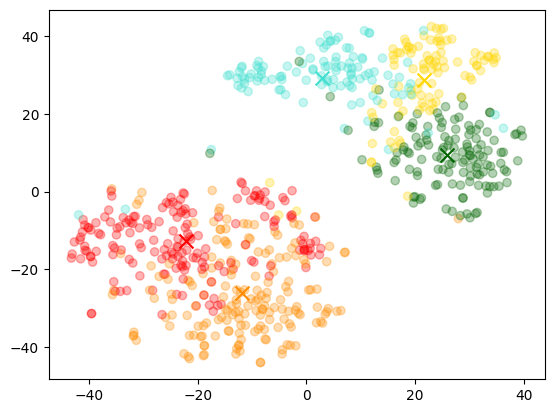

In [206]:
plot(df.Cluster, vis_dims)

# Explain Categories

In [208]:

# Reading a review which belong to each group.
n_clusters = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .feedback.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(n_clusters, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="gpt-35-turbo",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        # temperature=0,
        # max_tokens=64,
        top_p=1,
        # frequency_penalty=0,
        # presence_penalty=0,
    )
    print(response["choices"][0]["text"])

    sample_cluster_rows = df[df.Cluster == i].sample(n_clusters, random_state=42)
    for j in range(n_clusters):
        print(sample_cluster_rows.label.values[j], end=", ")
        # print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.feedback.str[:700].values[j])

    print("-" * 100)

Cluster 0 Theme:  Return business

### Example use case: 

Customer reviews can be used track customer
1, Customer plans to go back next trip out.
1, Customer is extremely satisfied with their experience.
1, Customers appreciated the awesome selection of beer.
1, Customer had high expectations and the restaurant exceeded them.
1, Customer highly recommends the restaurant, assuring others they won't be disappointed.
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  There are several mentions of customers not being satisfied with the taste of the food.


0, Customer disliked a certain menu item (not specified) and expressed hatred towards it.
0, Customer had high expectation for the burgers cooked over charcoal grill, but unfortunately fell short in taste.
0, Customer is disappointed with the taste of the Indian cuisine, describes it as the blandest food they ever ate.
0, Customer found the mac salad to be lacking in fl

# Search

In [209]:
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.ada_embedding.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .comment.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
    return results

In [210]:
results = search_reviews(df, "yummy", n=3)

I can say that the desserts were yummy.
Now this dish was quite flavourful.
So flavorful and has just the perfect amount of heat.


In [211]:
results = search_reviews(df, "shit", n=3)

But now I was completely grossed out.
I was VERY disappointed!!
I vomited in the bathroom mid lunch.


In [212]:
results = search_reviews(df, "fish", n=3)

You get incredibly fresh fish, prepared with care.
The yellowtail carpaccio was melt in your mouth fresh.
I got to enjoy the seafood salad, with a fabulous vinegrette.


In [213]:
results = search_reviews(df, "chicken", n=3)

The chicken was deliciously seasoned and had the perfect fry on the outside and moist chicken on the inside.
The Han Nan Chicken was also very tasty.
High-quality chicken on the chicken Caesar salad.


In [214]:
results = search_reviews(df, "beef", n=3)

The burger is good beef, cooked just right.
The chicken dishes are OK, the beef is like shoe leather.
The roast beef sandwich tasted really good!


In [215]:
from sklearn.metrics.pairwise import cosine_similarity as cs

In [216]:
a = []
for i in df.ada_embedding.values:
    a.append(i)
a = np.array(a)

In [217]:
symmetric_matrix = cs(a, a)

In [218]:
symmetric_matrix

array([[1.        , 0.82730988, 0.83939782, ..., 0.88596692, 0.85141532,
        0.85096252],
       [0.82730988, 1.        , 0.91083727, ..., 0.86704609, 0.85368822,
        0.8578556 ],
       [0.83939782, 0.91083727, 1.        , ..., 0.89443846, 0.88895798,
        0.86908097],
       ...,
       [0.88596692, 0.86704609, 0.89443846, ..., 1.        , 0.90093495,
        0.88705147],
       [0.85141532, 0.85368822, 0.88895798, ..., 0.90093495, 1.        ,
        0.86618237],
       [0.85096252, 0.8578556 , 0.86908097, ..., 0.88705147, 0.86618237,
        1.        ]])

In [219]:
arg_max = symmetric_matrix.argsort(axis=1)[:,::-1]

In [220]:
arg_max

array([[  0, 288, 425, ..., 127, 537, 218],
       [  1, 276, 527, ..., 158, 598,  55],
       [  2, 527, 679, ...,  55, 598, 487],
       ...,
       [689,  91, 471, ...,  96, 611, 218],
       [690, 190, 398, ..., 611, 285, 218],
       [691, 647, 535, ..., 447, 487, 218]])

In [221]:
for i in range(10):
    print(df.loc[i, "feedback"], "|||", df.loc[arg_max[i][1], "feedback"])

Customer had a great experience at the place. ||| Customer had a fantastic experience.
Customer did not like the crust. ||| Customer had a negative experience with the crust being too tough to eat.
Customer found the food not tasty with unpleasant texture. ||| Customer did not like the taste of the food.
Customer visited the place based on Rick Steve recommendation and loved it. ||| Customer had a great experience at the place.
Customer appreciated great menu selection and reasonable prices. ||| Customer enjoyed the outstanding food and found the prices to be very reasonable.
Customer is angry and wants their pho. ||| Customer is very angry and dissatisfied.
Customer thinks the food wasn't very fresh, but not terrible. ||| Customer was not satisfied with the service and thought the food was mediocre.
Customer didn't like the potatoes which felt like they were pre-made and kept under a warmer. ||| Customer was disappointed with the fresh batch of fries that were not warm.
Customer liked

# Observations
- label error
- translate error, ironic, biased, preprocess prompt(high cost)

# Applications

### TM
- OLH recommendation
- Case clustering, Report generation


### IIA
- Email clustering
- Identity Graph similarity, account attribute, sign-in time, freq, behaviors
    - Attack matching, prediction
- User habbit finding

### Improving
- Labeling -> Low Cost Modeling